# Init

In [21]:
!pip install --upgrade gensim
!pip install tqdm

In [22]:
import pickle
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [23]:
with open('pickle/df_proc.p', 'rb') as file:
    df = pickle.load(file)
df.head()

,text
0,programa treinamento jornalismo agroindústria ...
1,ofício enviado sergio presidente michel esquiv...
2,governador sérgio cabral transferido complexo ...
3,aplausos federal sergio responsável operação i...
4,executivo empreiteira odebrecht afirmou acordo...


# Process LDA

In [24]:
tokenized_docs = [doc.lower().split() for doc in df['text']]

In [25]:
id2word = corpora.Dictionary(tokenized_docs)
corpus = [id2word.doc2bow(text) for text in tokenized_docs]

In [26]:
def compute_coherence_values(corpus, dictionary, texts, range_lda):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range_lda):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [27]:
limit=21; start=2; step=1;
range_lda = range(start, limit, step)
model_list, coherence_values = compute_coherence_values(corpus=corpus, dictionary=id2word, texts=tokenized_docs, range_lda=range_lda)

100%|██████████| 19/19 [01:44<00:00,  5.51s/it]


# Visualize Results

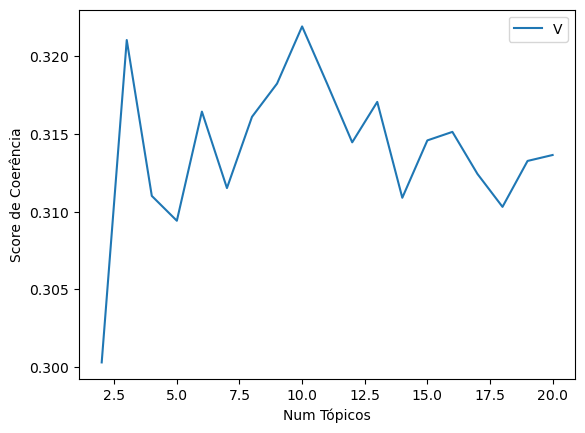

In [28]:
x = range_lda
plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()

In [29]:
for m, cv in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(cv, 4))

A quantidade de tópicos = 2  tem um valor de coerência de  0.3003
A quantidade de tópicos = 3  tem um valor de coerência de  0.321
A quantidade de tópicos = 4  tem um valor de coerência de  0.311
A quantidade de tópicos = 5  tem um valor de coerência de  0.3094
A quantidade de tópicos = 6  tem um valor de coerência de  0.3164
A quantidade de tópicos = 7  tem um valor de coerência de  0.3115
A quantidade de tópicos = 8  tem um valor de coerência de  0.3161
A quantidade de tópicos = 9  tem um valor de coerência de  0.3182
A quantidade de tópicos = 10  tem um valor de coerência de  0.3219
A quantidade de tópicos = 11  tem um valor de coerência de  0.3182
A quantidade de tópicos = 12  tem um valor de coerência de  0.3145
A quantidade de tópicos = 13  tem um valor de coerência de  0.3171
A quantidade de tópicos = 14  tem um valor de coerência de  0.3109
A quantidade de tópicos = 15  tem um valor de coerência de  0.3146
A quantidade de tópicos = 16  tem um valor de coerência de  0.3151
A qua

# Save best model

In [30]:
optimal_model_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[optimal_model_index]
optimal_num_topics = optimal_model.num_topics

print(f"Melhor número de tópicos: {optimal_num_topics}")

with open('pickle/optimal_model.p', 'wb') as file:
    pickle.dump(optimal_model, file)

Melhor número de tópicos: 10


# Visualize Words

In [31]:
def get_topic_words(lda_model, num_words=5):
    topic_words = {}
    for i, topic in enumerate(lda_model.show_topics(formatted=False, num_words=num_words)):
        topic_words[i] = [word for word, _ in topic[1]]
    return topic_words

In [32]:
topic_words = get_topic_words(optimal_model, num_words=5)

for topic, words in topic_words.items():
    print(f"Tópico {topic}: {' '.join(words)}")

Tópico 0: presidente governo pessoas brasil semana
Tópico 1: governo presidente brasil milhões cidade
Tópico 2: presidente brasil governo afirmou pessoas
Tópico 3: brasil presidente governo afirmou pessoas
Tópico 4: brasil presidente pessoas milhões governo
Tópico 5: presidente governo brasil pessoas processo
Tópico 6: presidente governo brasil milhões pessoas
Tópico 7: brasil presidente pessoas cidade afirmou
Tópico 8: governo presidente afirmou ministro brasil
Tópico 9: presidente brasil governo pessoas trabalho
